Crop Recommendation and Yield Prediction System
============================================

This module implements a complete system for crop recommendation and yield prediction
using machine learning techniques. It includes comprehensive data analysis,
preprocessing, model building, and evaluation.

Key Components:
- Data Loading and EDA
- Data Preprocessing
- Recommendation Model (Neural Network)
- Yield Prediction Model (XGBoost)
- Evaluation Metrics and Visualization

`Author: Pourya`

`Date: 11/12/2024`

In [ ]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [ ]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('siddharthss/crop-recommendation-dataset', path="/content/drive/MyDrive/ML/Crop Recommendation and Yield Prediction", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/siddharthss/crop-recommendation-dataset


In [ ]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('patelris/crop-yield-prediction-dataset', path="/content/drive/MyDrive/ML/Crop Recommendation and Yield Prediction", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset


# Import essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Any, Union
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Data Loading and Initial Setup

In [2]:
def load_data(recommendation_path: str, yield_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load the recommendation and yield datasets from specified paths.

    Args:
        recommendation_path: Path to crop recommendation dataset
        yield_path: Path to crop yield dataset

    Returns:
        Tuple of (recommendation_df, yield_df)

    Raises:
        FileNotFoundError: If either file is not found
    """
    try:
        data_recom = pd.read_csv(recommendation_path)
        data_yield = pd.read_csv(yield_path)
        print(f"Successfully loaded datasets:")
        print(f"Recommendation data shape: {data_recom.shape}")
        print(f"Yield data shape: {data_yield.shape}")
        return data_recom, data_yield
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        raise

# Exploratory Data Analysis

In [3]:
def perform_eda(data_recom: pd.DataFrame, data_yield: pd.DataFrame) -> None:
    """
    Perform comprehensive exploratory data analysis on both datasets.

    Args:
        data_recom: Crop recommendation dataset
        data_yield: Crop yield dataset
    """
    # Recommendation Dataset Analysis
    print("\n=== Crop Recommendation Dataset Analysis ===")
    print("\nBasic Information:")
    print(data_recom.info())

    print("\nSummary Statistics:")
    print(data_recom.describe())

    # Visualize distribution of crops
    plt.figure(figsize=(15, 6))
    sns.countplot(data=data_recom, y='label')
    plt.title('Distribution of Crops in Recommendation Dataset')
    plt.show()

    # Correlation matrix for numerical features
    plt.figure(figsize=(10, 8))
    sns.heatmap(data_recom.select_dtypes(include=[np.number]).corr(),
                annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix - Recommendation Features')
    plt.show()

    # Yield Dataset Analysis
    print("\n=== Crop Yield Dataset Analysis ===")
    print("\nBasic Information:")
    print(data_yield.info())

    # Filter for India
    india_yield = data_yield[data_yield['Area'] == 'India']

    # Visualize yield trends over time
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=india_yield, x='Item', y='hg/ha_yield')
    plt.xticks(rotation=45)
    plt.title('Yield Distribution by Crop Type in India')
    plt.show()

# Data Preprocessing

In [4]:
def preprocess_recommendation_data(data: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, Any]:
    """
    Preprocess the recommendation dataset for model training.

    Args:
        data: Raw recommendation dataset

    Returns:
        Tuple of (X, y, label_encoder)
    """
    from sklearn.preprocessing import LabelEncoder

    # Separate features and target
    X = data.drop('label', axis=1)
    y = data['label']

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    y = y.reshape(-1, 1)

    print("Preprocessing complete:")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Number of unique crops: {len(label_encoder.classes_)}")

    return X, y, label_encoder

In [5]:
def preprocess_yield_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, Any]:
    """
    Preprocess the yield dataset for model training.

    Args:
        data: Raw yield dataset

    Returns:
        Tuple of (X, y, label_encoder)
    """
    from sklearn.preprocessing import LabelEncoder

    # Filter for India and drop unnecessary columns
    india_data = data[data['Area'] == 'India'].copy()
    X = india_data.drop(columns=['hg/ha_yield', 'Area', 'Unnamed: 0'])
    y = india_data['hg/ha_yield']

    # Encode crop items
    label_encoder = LabelEncoder()
    X['Item'] = label_encoder.fit_transform(X['Item'])

    return X, y, label_encoder

# Model Building - Recommendation System

In [6]:
def build_recommendation_model(input_dim: int) -> 'keras.Model':
    """
    Build and compile the neural network model for crop recommendation.

    Args:
        input_dim: Number of input features

    Returns:
        Compiled Keras model
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout

    model = Sequential([
        Dense(100, input_dim=input_dim, activation='relu'),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(22, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [7]:
def train_recommendation_model(
    X: np.ndarray,
    y: np.ndarray,
    model: 'keras.Model',
    validation_split: float = 0.2,
    epochs: int = 50,
    batch_size: int = 20
) -> 'keras.callbacks.History':
    """
    Train the recommendation model and return training history.

    Args:
        X: Training features
        y: Training targets
        model: Compiled Keras model
        validation_split: Proportion of data for validation
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        Training history
    """
    from sklearn.model_selection import train_test_split

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=validation_split, random_state=RANDOM_SEED
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    return history, (X_test, y_test)

In [8]:
def evaluate_recommendation_model(
    model: 'keras.Model',
    X_test: np.ndarray,
    y_test: np.ndarray,
    label_encoder: Any
) -> None:
    """
    Evaluate the recommendation model and display metrics.

    Args:
        model: Trained model
        X_test: Test features
        y_test: Test targets
        label_encoder: Fitted label encoder
    """
    from sklearn.metrics import classification_report, confusion_matrix

    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_flat = y_test.ravel()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        y_test_flat,
        y_pred_classes,
        target_names=label_encoder.classes_
    ))

    # Plot confusion matrix
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        confusion_matrix(y_test_flat, y_pred_classes),
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    plt.title('Confusion Matrix - Crop Recommendation')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [9]:
def plot_training_history(history: 'keras.callbacks.History') -> None:
    """
    Plot training and validation metrics history.

    Args:
        history: Training history from model.fit()
    """
    hist_df = pd.DataFrame(history.history)

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist_df['loss'], label='Training Loss')
    plt.plot(hist_df['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist_df['accuracy'], label='Training Accuracy')
    plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Model Building - Yield Prediction

In [10]:
def build_yield_model() -> 'xgboost.XGBRegressor':
    """
    Build and configure XGBoost model for yield prediction.

    Returns:
        Configured XGBoost regressor
    """
    import xgboost as xgb

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=10,
        random_state=RANDOM_SEED
    )

    return model

In [11]:
def train_evaluate_yield_model(
    X: pd.DataFrame,
    y: pd.Series,
    model: 'xgboost.XGBRegressor'
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Train and evaluate the yield prediction model.

    Args:
        X: Features
        y: Targets
        model: XGBoost model

    Returns:
        Tuple of (rmse, y_test, predictions)
    """
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
    )

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"Yield Prediction RMSE: {rmse:.2f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Yield')
    plt.ylabel('Predicted Yield')
    plt.title('Actual vs Predicted Crop Yield')
    plt.show()

    return rmse, y_test, predictions

# Model Saving and Loading

In [12]:
def save_models(
    recom_model: 'keras.Model',
    yield_model: 'xgboost.XGBRegressor',
    recom_encoder: Any,
    yield_encoder: Any,
    output_dir: str = 'models'
) -> None:
    """
    Save all models and encoders to disk.

    Args:
        recom_model: Trained recommendation model
        yield_model: Trained yield prediction model
        recom_encoder: Fitted recommendation label encoder
        yield_encoder: Fitted yield label encoder
        output_dir: Directory to save models
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save recommendation model and encoder
    recom_model.save(os.path.join(output_dir, 'recommendation.keras'))
    joblib.dump(recom_encoder, os.path.join(output_dir, 'recommendation_encoder.joblib'))

    # Save yield model and encoder
    joblib.dump(yield_model, os.path.join(output_dir, 'yield_model.joblib'))
    joblib.dump(yield_encoder, os.path.join(output_dir, 'yield_encoder.joblib'))

    print(f"All models and encoders saved to {output_dir}")

# Main function

In [14]:
# 1. Load Data
data_recom, data_yield = load_data('/content/drive/MyDrive/ML/Crop Recommendation and Yield Prediction/Crop_recommendation.csv', '/content/drive/MyDrive/ML/Crop Recommendation and Yield Prediction/yield_df.csv')

Successfully loaded datasets:
Recommendation data shape: (2200, 8)
Yield data shape: (28242, 8)



=== Crop Recommendation Dataset Analysis ===

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

Summary Statistics:
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000    

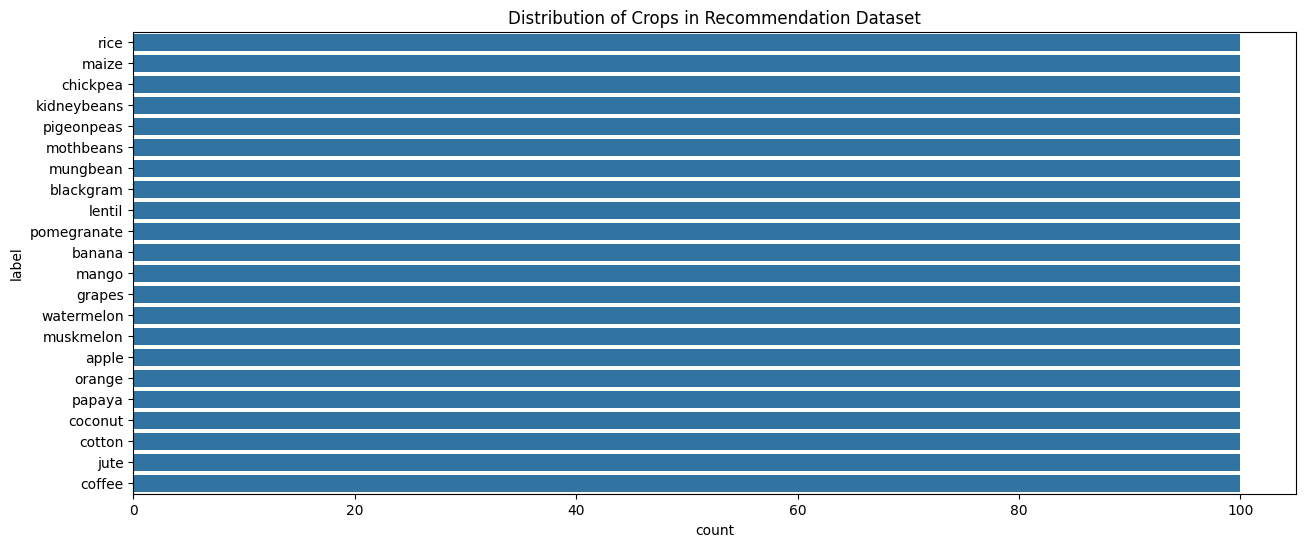

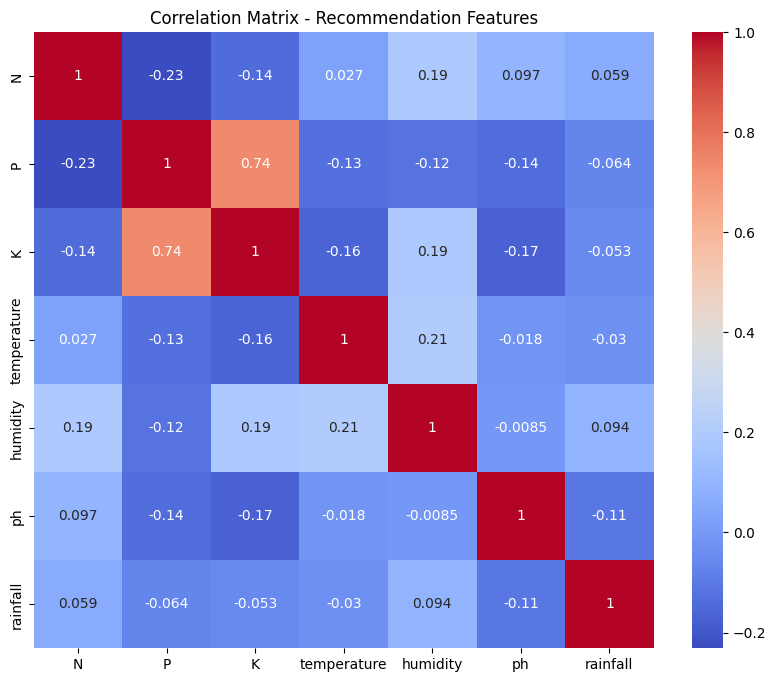


=== Crop Yield Dataset Analysis ===

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB
None


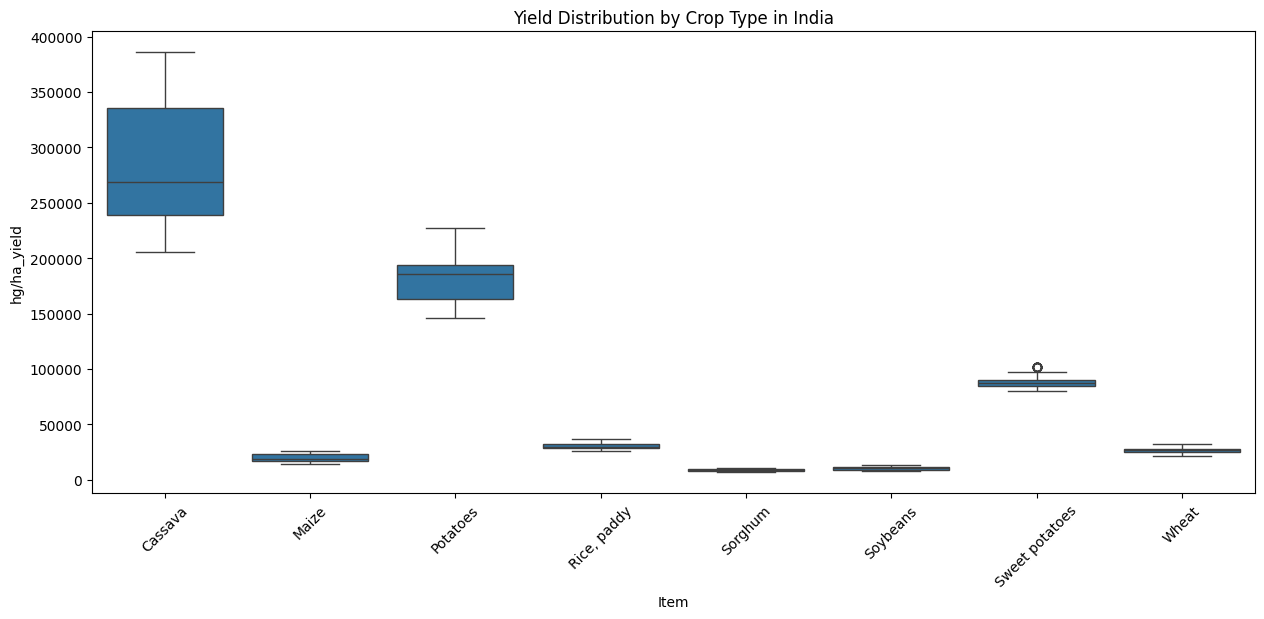

In [15]:
# 2. Perform EDA
perform_eda(data_recom, data_yield)

In [16]:
# 3. Preprocess Data
X_recom, y_recom, recom_encoder = preprocess_recommendation_data(data_recom)
X_yield, y_yield, yield_encoder = preprocess_yield_data(data_yield)

Preprocessing complete:
Features shape: (2200, 7)
Target shape: (2200, 1)
Number of unique crops: 22


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1191 - loss: 17.2621 - val_accuracy: 0.6875 - val_loss: 1.4099
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5162 - loss: 1.7151 - val_accuracy: 0.7614 - val_loss: 0.8878
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6465 - loss: 1.1321 - val_accuracy: 0.8182 - val_loss: 0.6692
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7169 - loss: 0.8765 - val_accuracy: 0.8494 - val_loss: 0.4632
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7667 - loss: 0.6692 - val_accuracy: 0.8977 - val_loss: 0.3792
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.5701 - val_accuracy: 0.9261 - val_loss: 0.2723
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8190 - loss: 0.5207 - val_accuracy: 0.8920 - val_loss: 0.2796
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8504 - loss: 0.4525 - val_accuracy: 0.9375 - val_loss

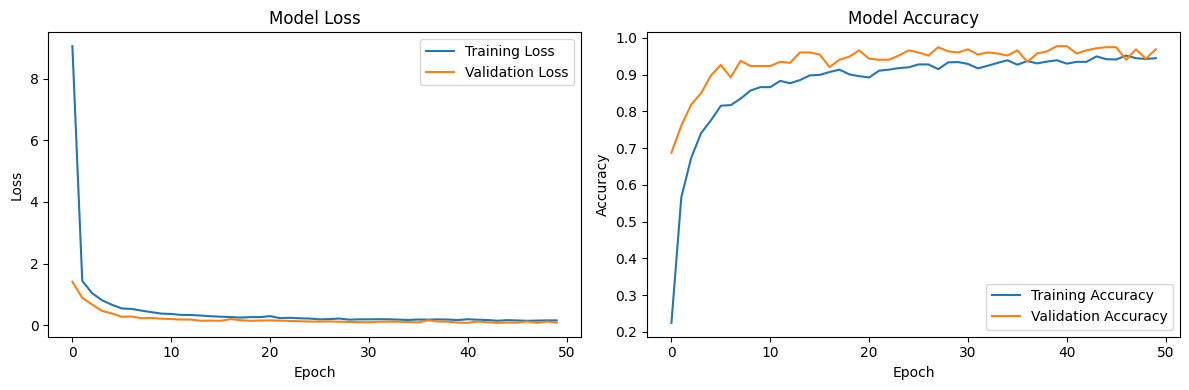

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       0.95      1.00      0.98        21
   blackgram       0.90      0.95      0.93        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      0.96      0.98        27
      coffee       1.00      0.94      0.97        17
      cotton       0.82      0.82      0.82        17
      grapes       1.00      1.00      1.00        14
        jute       0.81      0.91      0.86        23
 kidneybeans       0.95      1.00      0.98        20
      lentil       1.00      0.91      0.95        11
       maize       0.84      0.76      0.80        21
       mango       1.00      1.00      1.00        19
   mothbeans       0.89      1.00      0.94        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange      

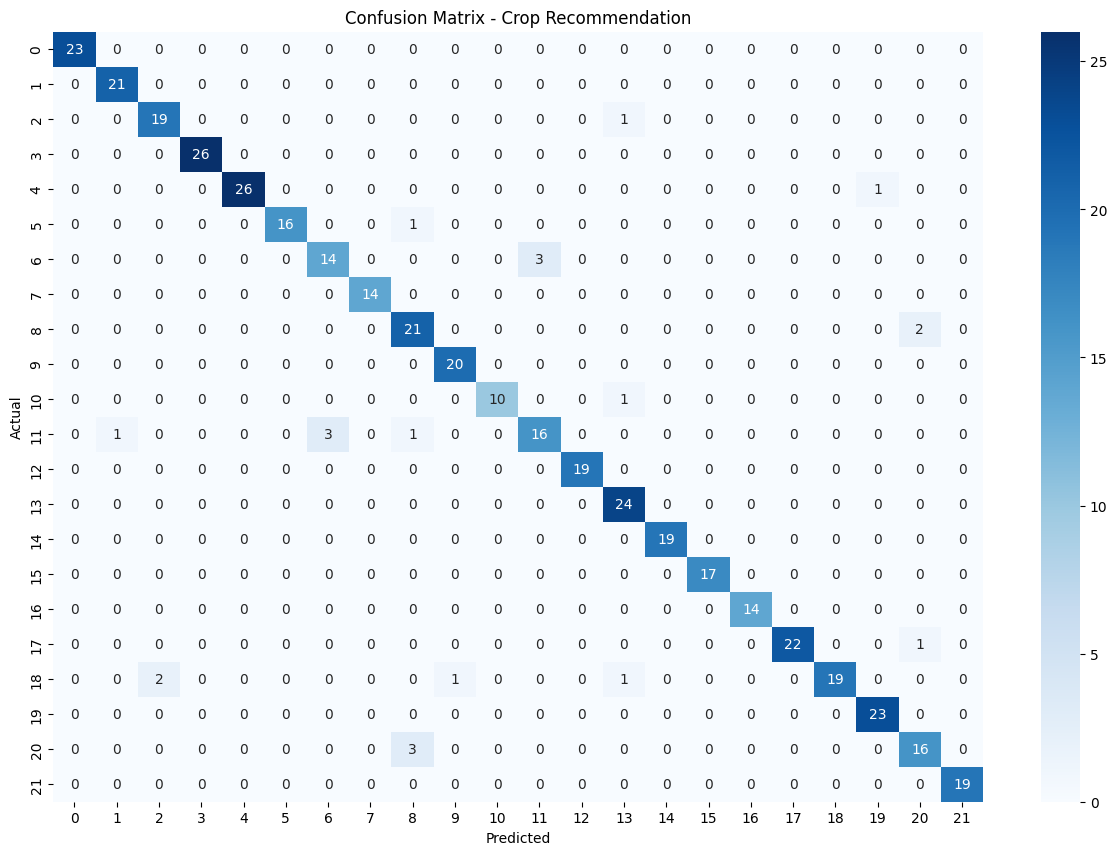

In [17]:
# 4. Build and Train Recommendation Model
recom_model = build_recommendation_model(X_recom.shape[1])
history, test_data = train_recommendation_model(X_recom, y_recom, recom_model)
plot_training_history(history)
evaluate_recommendation_model(recom_model, test_data[0], test_data[1], recom_encoder)

Yield Prediction RMSE: 3510.67


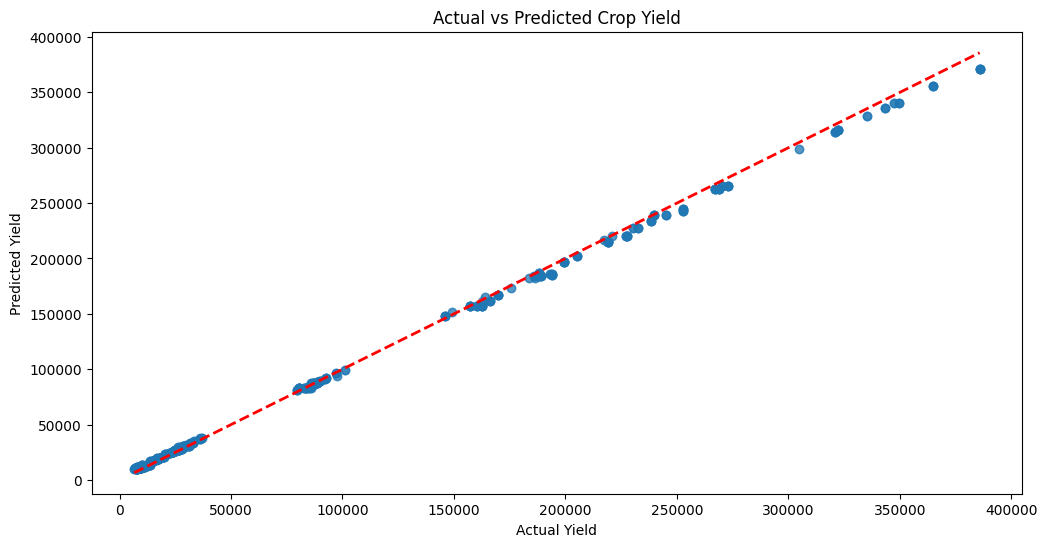

In [18]:
# 5. Build and Train Yield Model
yield_model = build_yield_model()
rmse, y_test, predictions = train_evaluate_yield_model(X_yield, y_yield, yield_model)

In [19]:
# 6. Save Models
save_models(recom_model, yield_model, recom_encoder, yield_encoder)

All models and encoders saved to models
